In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import nltk
import re
import matplotlib.pyplot as plt
import unicodedata 
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time

In [17]:
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    else:
        text = text.lower().strip()
        text = str(unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8'))
        return text

department_alias_map = {
    # MATEMÁTICAS y Estadística
    "mate 3" : "matemáticas",
    "matematicas": "matemáticas",
    "Álgebra lineal 1": "matemáticas", 
    "Estadidística": "estadística",
    "estadistica 2": "estadística",
    "Estadistica": "estadística",
    "Estadistica/ actuaria": "estadística", 
    "Estadistica/Laboratorista": "estadística",
    "Estadística": "estadística", 
    "Estadística I": "estadística", 
    "Estadística y Actuaria": "estadística", 
    "Estadística/Economía": "estadística", 
    "Estadística/Matemáticas": "estadística", 
    
    #ADMINISTRACIÓN Y CONTABILIDAD
    "ADM" : "administracion", 
    "ADMINISTRACION": "administracion",
    "Administracion": "administracion", 
    "Administración": "administracion", 
    "Administración Internacional": "administracion", 
    "Administración de Empresas": "administracion",
    "Administración/Estadística": "administracion",
    "Admninistración": "administracion", 
    "Admon": "administracion",
    "Conta": "contabilidad", 
    "Contabilidad": "contabilidad",  
    "Contabilidad I": "contabilidad", 
    "Contabilidad.": "contabilidad", 

    ## Actuaria
    "Actuar?a": "actuaria",
    "Actuaria": "actuaria",
    "Actuaria y Finanzas": "actuaria",
    "Actuaria y Seguros": "actuaria", 
    "Actuaría": "actuaria", 
    "Actuaría y Seguros": "actuaria",

    #Copmutación
    "Computacion": "computación",
    "HCA": "computación", 
    "Computación": "computación", 

    #Ciencia política
    "Ciencia Politica": "ciencia política", 
    "Ciencia Política": "ciencia política",
    "Ciencia política": "ciencia política",
    "Ciencias politicas" : "ciencia política",

    #Economía
    "Eco 2": "economía",
    "Econom?a": "economía", 
    "Econometría": "economía", 
    "Economia": "economía",
    "Economia 1": "economía",
    "Economia I": "economía",
    "Economia/Micro": "economía", 
    "Economìa": "economía", 
    "Economía": "economía",
    "Economía 1": "economía", 
    "Economía 2": "economía", 
    "Economía 4": "economía",

    #COMUNICACIÓN Y ESTUDIOS GENERALES
    "Estrategia de Comunicación Escrita": "Estrategias de comunicación escrita",
    "Estrategias de Comunicación": "Estrategias de comunicación escrita", 
    "Estrategias de Comunicación Escrita": "Estrategias de comunicación escrita", 
    "Estrategias de comunicación": "Estrategias de comunicación escrita", 
    "Estrategias de comunicación escrita": "Estrategias de comunicación escrita", 
    "Estrategias de la Comunicación Escrita": "Estrategias de comunicación escrita",
    "Estrategias de la comunicación escrita": "Estrategias de comunicación escrita",
    " Estudios Generalea": "Estudios generales", 
    "Estudios Generales": "Estudios generales",
    "Estudios generales": "Estudios generales",
    "Estudiosgenerales": "Estudios generales", 
    "Ideas I": "Estudios generales",
    "Ideas e Instituciones Políticas y Sociales 1": "Estudios generales",
    "Ideas e Instituciones Políticas y Sociales III": "Estudios generales"
    

}


In [13]:

# Configuración de Selenium
opciones = Options()
opciones.add_argument("--headless")  # No abre ventana del navegador
servicio = Service(r'C:\\Users\\joacr\\Downloads\\chromedriver.exe.')  # Descarga ChromeDriver para tu versión de Chrome

driver = webdriver.Chrome(service=servicio, options=opciones)

driver.get('https://www.misprofesores.com/escuelas/ITAM-Instituto-Tecnologico-Autonomo-de-Mexico_1003')

time.sleep(5)

#  HTML final
html = driver.page_source
soup = BeautifulSoup(html, 'lxml')
filas = soup.find_all("tr", role="row")
print(len(filas))

driver.quit()


1508


In [14]:
filas

[<tr role="row"><th aria-label="" class="sorting_disabled" colspan="1" rowspan="1" style="width: 52px;"></th><th aria-controls="profesores" aria-label="Apellido, Nombre: activate to sort column descending" aria-sort="ascending" class="url hidden-xs sorting_asc" colspan="1" rowspan="1" style="width: 0px;" tabindex="0">Apellido, Nombre</th><th aria-controls="profesores" aria-label="Nombre / Depto: activate to sort column ascending" class="visible-xs sorting" colspan="1" rowspan="1" style="width: 407px;" tabindex="0">Nombre / Depto</th><th aria-label="Departamento / Facultad" class="hidden-xs sorting_disabled" colspan="1" rowspan="1" style="width: 0px;">Departamento / Facultad</th><th aria-label="# de calif." class="sorting_disabled" colspan="1" rowspan="1" style="width: 83px;"># de calif.</th><th aria-label="Promedio" class="sorting_disabled" colspan="1" rowspan="1" style="width: 87px;">Promedio</th></tr>,
 <tr class="odd" role="row"><td><img src="https://storage.googleapis.com/misprofes

### Departamentos disponibles

In [18]:
import requests
from bs4 import BeautifulSoup
from collections import defaultdict
import time
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk


# --- Parte 1: Extracción de datos de profesores (modificada para incluir URL) ---

profesores_data = []
all_ratings = [] # Para calcular el promedio global

for fila in filas:
    fila_soup = BeautifulSoup(str(fila), 'html.parser')

    # Excluir la primera fila que es la cabecera de la tabla
    if "Apellido, Nombre" in fila_soup.get_text():
        continue

    nombre_element = fila_soup.find('td', class_='url hidden-xs sorting_1')
    nombre_profesor = ""
    profesor_url = ""

    if nombre_element:
        a_tag = nombre_element.find('a')
        if a_tag and 'href' in a_tag.attrs:
            profesor_url = a_tag['href']

        b_tag = nombre_element.find('b')
        if b_tag:
            full_name_text = nombre_element.get_text(strip=True)
            full_name_parts = [part.strip() for part in full_name_text.split(',')]
            if len(full_name_parts) > 1:
                apellido = full_name_parts[0]
                nombre_pila = full_name_parts[1]
                nombre_profesor = f"{nombre_pila} {apellido}"
            else:
                nombre_profesor = b_tag.get_text(strip=True)

    normalized_department_alias_map = {
        normalize_text(k): v
        for k, v in department_alias_map.items()
    }
    departamento_element = fila_soup.find('span', style="font-size:12px;")
    raw_departamento = departamento_element.get_text(strip=True) if departamento_element else "Desconocido"
    normalized_departamento = normalize_text(raw_departamento)
    departamento = normalized_department_alias_map.get(normalized_departamento, normalized_departamento)



    calificacion_element = fila_soup.find_all('td')[-1]
    calificacion_text = calificacion_element.find('b')
    calificacion = None
    if calificacion_text and calificacion_text.get_text(strip=True):
        try:
            calificacion = float(calificacion_text.get_text(strip=True))
        except ValueError:
            calificacion = None

    num_calif_element = fila_soup.find_all('td')[-2]
    num_calificaciones = None
    if num_calif_element and num_calif_element.get_text(strip=True):
        try:
            num_calificaciones = int(num_calif_element.get_text(strip=True))
        except ValueError:
            num_calificaciones = 0

    if nombre_profesor and departamento and calificacion is not None and num_calificaciones is not None and profesor_url:
        profesores_data.append({
            "nombre": nombre_profesor,
            "departamento": departamento,
            "calificacion": calificacion,
            "num_calificaciones": num_calificaciones,
            "url": profesor_url
        })
        all_ratings.append(calificacion)

# Calificación promedio global (C)
C = sum(all_ratings) / len(all_ratings) if all_ratings else 0.0

#Umbral mínimo de calificaciones (m)
m = 5

# Puntuación ponderada para cada profesor
for prof in profesores_data:
    R = prof["calificacion"]
    v = prof["num_calificaciones"]
    if (v + m) == 0:
        prof["puntuacion_ponderada"] = R
    else:
        prof["puntuacion_ponderada"] = ((R * v) + (C * m)) / (v + m)

clasificacion_por_departamento = defaultdict(list)

for prof in profesores_data:
    clasificacion_por_departamento[prof["departamento"]].append(prof)

# Puntuación ponderada dentro de cada departamento (de mayor a menor)
for depto, profes in clasificacion_por_departamento.items():
    clasificacion_por_departamento[depto] = sorted(profes, key=lambda x: x["puntuacion_ponderada"], reverse=True)

print("Departamentos disponibles:")
for depto in sorted(clasificacion_por_departamento.keys()):
    print(f"- {depto}")

Departamentos disponibles:
- Estrategias de comunicación escrita
- Estudios generales
- actuaria
- administracion
- administracion / finanzas
- administracion-finanzas
- algebra superior
- alvarado
- arguelles
- arquitectura
- biologo de penes
- c.pol
- calculo
- calculo de probabilidades i
- cambio climatico
- cch azcapotzalco
- centro de estudios del bienestar
- ciencia de datos
- ciencia política
- cisneros
- computación
- comunicacion profesional para direccion financiera
- comunicacion y diseno
- conocimiento generales
- contabilidad
- contabilidad/derecho
- contaduria
- contaduria y administracion
- cpol
- departamento
- departamento academico de lenguas
- departamento de derecho
- departamento de estadistica
- departamento de lenguas
- departamento de lenguas (ingles)
- deportes tocho
- derecho
- derecho / analisis economico del derecho
- derecho constitucional ll/der pub
- derecho empresarial
- derecho laboral
- derecho ublico
- desarrollo ejecutivo
- dessavre
- diplomado
- dip

### Profesores por departamento ordenados de mayor a menor calificación

In [24]:
from bs4 import BeautifulSoup
from collections import defaultdict
# Clasificar por departamento
clasificacion_por_departamento = defaultdict(list)

for prof in profesores_data:
    clasificacion_por_departamento[prof["departamento"]].append(prof)

# Calificación dentro de cada departamento (de mayor a menor)
for depto, profes in clasificacion_por_departamento.items():
    clasificacion_por_departamento[depto] = sorted(profes, key=lambda x: x["calificacion"], reverse=True)

# Imprimir los resultados
for depto, profes in clasificacion_por_departamento.items():
    print(f"\n--- Departamento: {depto} ---")
    for prof in profes:
        print(f"  Nombre: {prof['nombre']}, Calificación: {prof['calificacion']}, Votos: {prof['num_calificaciones']}")




--- Departamento: ing. industrial y operaciones ---
  Nombre: Graciela Guadalupe Díaz Argomedo, Calificación: 10.0, Votos: 1
  Nombre: Gerardo Nepomuceno, Calificación: 10.0, Votos: 1
  Nombre: Luis Vicente Montiel Cendejas, Calificación: 9.0, Votos: 6
  Nombre: Adrian Ramirez Nafarrate, Calificación: 9.0, Votos: 1
  Nombre: Adán Ramírez López, Calificación: 8.1, Votos: 10
  Nombre: Miguel Francisco de Lascurain Morhan, Calificación: 8.0, Votos: 21
  Nombre: Ida Caterina García Appendini, Calificación: 7.8, Votos: 13
  Nombre: Víctor Cruz Morales, Calificación: 7.6, Votos: 8
  Nombre: Alfonso Jaime Acosta Mejía, Calificación: 7.5, Votos: 4
  Nombre: Asali Guillermo Abdel Musik, Calificación: 7.3, Votos: 19
  Nombre: Sergio Romero Hernández, Calificación: 7.0, Votos: 21
  Nombre: Alejandro Terán Castellanos, Calificación: 6.9, Votos: 39
  Nombre: David Fernando Muñoz Negrón, Calificación: 5.9, Votos: 14
  Nombre: Omar Romero Hernández, Calificación: 5.8, Votos: 6
  Nombre: María Cristi

### Profesores por departamento en orden por puntuación ponderada

In [25]:
from bs4 import BeautifulSoup
from collections import defaultdict


for prof in profesores_data:
    R = prof["calificacion"]
    v = prof["num_calificaciones"]
    if (v + m) == 0: # Caso extremo donde v y m son 0
        prof["puntuacion_ponderada"] = R
    else:
        prof["puntuacion_ponderada"] = ((R * v) + (C * m)) / (v + m)

clasificacion_por_departamento = defaultdict(list)

for prof in profesores_data:
    clasificacion_por_departamento[prof["departamento"]].append(prof)

# Ordenar por puntuación ponderada dentro de cada departamento (de mayor a menor)
for depto, profes in clasificacion_por_departamento.items():
    clasificacion_por_departamento[depto] = sorted(profes, key=lambda x: x["puntuacion_ponderada"], reverse=True)

#Resultados
for depto, profes in clasificacion_por_departamento.items():
    print(f"\n--- Departamento: {depto} ---")
    for prof in profes:
        print(f"  Nombre: {prof['nombre']}, Calificación: {prof['calificacion']:.1f}, # Calificaciones: {prof['num_calificaciones']}, Puntuación Ponderada: {prof['puntuacion_ponderada']:.2f}")



--- Departamento: ing. industrial y operaciones ---
  Nombre: Luis Vicente Montiel Cendejas, Calificación: 9.0, # Calificaciones: 6, Puntuación Ponderada: 8.25
  Nombre: Miguel Francisco de Lascurain Morhan, Calificación: 8.0, # Calificaciones: 21, Puntuación Ponderada: 7.87
  Nombre: Adán Ramírez López, Calificación: 8.1, # Calificaciones: 10, Puntuación Ponderada: 7.85
  Nombre: Graciela Guadalupe Díaz Argomedo, Calificación: 10.0, # Calificaciones: 1, Puntuación Ponderada: 7.79
  Nombre: Gerardo Nepomuceno, Calificación: 10.0, # Calificaciones: 1, Puntuación Ponderada: 7.79
  Nombre: Ida Caterina García Appendini, Calificación: 7.8, # Calificaciones: 13, Puntuación Ponderada: 7.67
  Nombre: Adrian Ramirez Nafarrate, Calificación: 9.0, # Calificaciones: 1, Puntuación Ponderada: 7.62
  Nombre: Víctor Cruz Morales, Calificación: 7.6, # Calificaciones: 8, Puntuación Ponderada: 7.50
  Nombre: Alfonso Jaime Acosta Mejía, Calificación: 7.5, # Calificaciones: 4, Puntuación Ponderada: 7.41


In [26]:
# --- Parte 2: Interacción con el usuario y visualización de profesores ---

departamento_solicitado = input("\nPor favor, ingresa el nombre exacto del departamento que te interesa: ").strip()

profesores_seleccionados = clasificacion_por_departamento.get(departamento_solicitado)

if profesores_seleccionados:
    print(f"\n--- Profesores en {departamento_solicitado} (Ordenados por Puntuación Ponderada) ---")
    for prof in profesores_seleccionados:
        print(f"  Nombre: {prof['nombre']}, Calificación: {prof['calificacion']:.1f}, # Calificaciones: {prof['num_calificaciones']}, Puntuación Ponderada: {prof['puntuacion_ponderada']:.2f}")
else:
    print(f"No se encontraron profesores para el departamento '{departamento_solicitado}'. Por favor, verifica la ortografía.")



Por favor, ingresa el nombre exacto del departamento que te interesa:  economía



--- Profesores en economía (Ordenados por Puntuación Ponderada) ---
  Nombre: Christina Cornejo Van Luit, Calificación: 9.5, # Calificaciones: 152, Puntuación Ponderada: 9.43
  Nombre: Jorge Rocha, Calificación: 10.0, # Calificaciones: 10, Puntuación Ponderada: 9.11
  Nombre: Sofia Corona Verduzco, Calificación: 9.7, # Calificaciones: 12, Puntuación Ponderada: 9.01
  Nombre: Bárbara Carrillo, Calificación: 9.1, # Calificaciones: 84, Puntuación Ponderada: 9.00
  Nombre: Francisco Rafael Padilla, Calificación: 9.2, # Calificaciones: 33, Puntuación Ponderada: 8.96
  Nombre: Jose Alberto Jimenez Hernandez, Calificación: 9.1, # Calificaciones: 53, Puntuación Ponderada: 8.95
  Nombre: Antonio Vivanco Casamadrid, Calificación: 9.6, # Calificaciones: 11, Puntuación Ponderada: 8.89
  Nombre: Fancisco Javier Varela Sandoval, Calificación: 9.1, # Calificaciones: 35, Puntuación Ponderada: 8.88
  Nombre: michelle segui perez, Calificación: 9.2, # Calificaciones: 23, Puntuación Ponderada: 8.87
  No


Selecciona un profesor para generar la nube de palabras de sus comentarios:
1. Christina Cornejo Van Luit
2. Jorge Rocha
3. Sofia Corona Verduzco
4. Bárbara Carrillo
5. Francisco Rafael Padilla
6. Jose Alberto Jimenez Hernandez
7. Antonio Vivanco Casamadrid
8. Fancisco Javier Varela Sandoval
9. michelle segui perez
10. Rafael Guerra Cabrera
11. Stefano Maximilian Lord
12. Claudia Aburto Rancaño
13. Mauricio Guzman
14. Mariana Padilla Toca
15. Vicente García Averell
16. Christiane Fabrega Chimali
17. JOSE OCTAVIO FIGUEROA RAMIREZ
18. Jose Alberto Jimenez
19. David Lamb de Valdes
20. Alejandro Arcadio Macías Melken
21. Jose Alberto Jimenez Hernandez
22. Marta Robles Cartes
23. Rodrigo Sánchez Gavito
24. Ana Bazua
25. Silvano Espíndola Flores
26. Magdalena Sofía Barba Fernández
27. Meney De la Peza Gandara
28. Alejandra Palacios
29. Patricia López Rodríguez
30. HUGO ALEJANDRO GARDUÑO ARREDONDO
31. Ana de Fatima Masse
32. Enrique Cárdenas
33. Victor Rodriguez
34. Sofía Verduzco
35. Martin

Ingresa el número del profesor:  26



Extrayendo comentarios para Magdalena Sofía Barba Fernández...
Visitando: https://www.misprofesores.com/profesores/Magdalena-Sofia-Barba-Fernandez_10775?pag=1


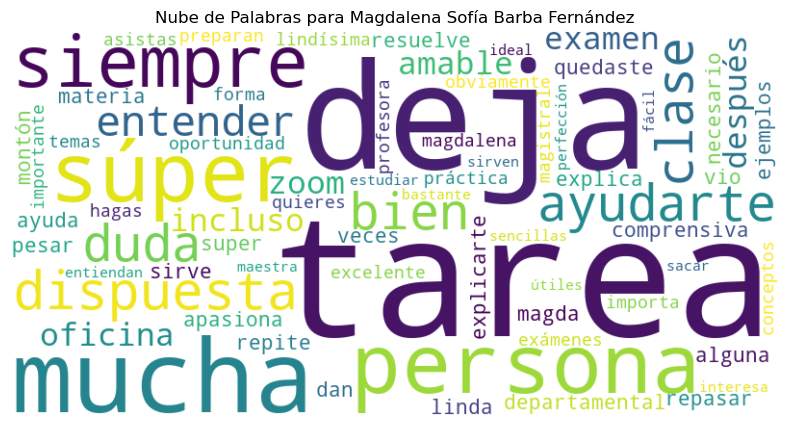

In [27]:
# --- Parte 3: Web Scraping de Comentarios y Nube de Palabras ---

if profesores_seleccionados:
    print("\nSelecciona un profesor para generar la nube de palabras de sus comentarios:")
    for i, prof in enumerate(profesores_seleccionados):
        print(f"{i+1}. {prof['nombre']}")

    while True:
        try:
            choice = int(input("Ingresa el número del profesor: "))
            if 1 <= choice <= len(profesores_seleccionados):
                selected_prof = profesores_seleccionados[choice - 1]
                break
            else:
                print("Número inválido. Intenta de nuevo.")
        except ValueError:
            print("Entrada inválida. Por favor, ingresa un número.")

    base_profesor_url = selected_prof['url'].split('?')[0] # Eliminar cualquier parámetro de paginación inicial

    all_comments_text = []
    current_page = 1
    max_pages = 1
    print(f"\nExtrayendo comentarios para {selected_prof['nombre']}...")

    while current_page <= max_pages:
        paginated_url = f"{base_profesor_url}?pag={current_page}"
        print(f"Visitando: {paginated_url}")
        try:
            response = requests.get(paginated_url)
            response.raise_for_status() # Lanza un error para códigos de estado HTTP erróneos
            soup = BeautifulSoup(response.text, 'html.parser')
            comment_tds = soup.find_all('td', class_='comments')
            for td_elem in comment_tds:
                comment_paragraph = td_elem.find("p", class_="commentsParagraph")
                if comment_paragraph:
                    for a_tag in comment_paragraph.find_all('a'):
                        a_tag.decompose()
                    all_comments_text.append(comment_paragraph.get_text(strip=True))

            
            # Encontrar el número máximo de páginas
            pagination_links = soup.find('div', class_='pagination')
            if pagination_links:
                # Buscar el último enlace de página (usualmente el '>' o el número más alto)
                # O los enlaces directos a números de página.
                page_numbers = []
                for link in pagination_links.find_all('a'):
                    try:
                        page_num = int(link.get_text(strip=True))
                        page_numbers.append(page_num)
                    except ValueError:
                        pass
                if page_numbers:
                    max_pages = max(max_pages, max(page_numbers)) 
           

            current_page += 1
            time.sleep(1) # Pausa para ser respetuoso con el servidor

        except requests.exceptions.RequestException as e:
            print(f"Error al acceder a la página {paginated_url}: {e}")
            break # Salir del bucle si hay un error de conexión
        except Exception as e:
            print(f"Ocurrió un error inesperado al procesar la página {paginated_url}: {e}")
            break # Salir del bucle por otros errores

    # --- Procesamiento de texto para la Nube de Palabras ---
    combined_comments = " ".join(all_comments_text)
    cleaned_text = re.sub(r'[^a-záéíóúüñ\s]', '', combined_comments.lower())
    words = cleaned_text.split()
    filtered_words = [word for word in words if word not in stopwords.words('spanish') and len(word) > 2] 
    final_text = " ".join(filtered_words)

    if final_text:
        #Nube de Palabras
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              collocations=False,
                              stopwords=stopwords.words('spanish')).generate(final_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Nube de Palabras para {selected_prof['nombre']}")
        plt.show()
    else:
        print("No se encontraron comentarios procesables para generar la nube de palabras.", final_text)
else:
    print("No se seleccionó ningún departamento válido para continuar con la extracción de comentarios.")
